<a href="https://colab.research.google.com/github/sabasimba200/Air-quality/blob/main/AirPollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import xarray as xr

In [ ]:
!pip install xee
import xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.3 MB/s eta 0:00:00


In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-smukonza', opt_url='https://earthengine.googleapis.com')

In [ ]:
map = geemap.Map(basemap = 'TERRAIN')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          119.619141,
                          21.708473
                        ],
                        [
                          119.619141,
                          25.700938
                        ],
                        [
                          122.563477,
                          25.700938
                        ],
                        [
                          122.563477,
                          21.708473
                        ],
                        [
                          119.619141,
                          21.708473
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [ ]:
nitrogen = (
    ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
    .filterDate('2018', '2025')
    .filterBounds(roi)
    .select(['NO2_column_number_density'], ['no2'])
)

nitrogen.first()

In [ ]:
ds = xr.open_dataset(nitrogen, engine= 'ee', crs = 'EPSG:4326', scale = 0.1, geometry = roi)
ds

<xarray.Dataset> Size: 25MB
Dimensions:  (time: 5401, lon: 29, lat: 40)
Coordinates:
  * time     (time) datetime64[ns] 43kB 2018-07-11T05:22:40 ... 2024-12-30T05...
  * lon      (lon) float64 232B 119.7 119.8 119.9 120.0 ... 122.3 122.4 122.5
  * lat      (lat) float64 320B 21.76 21.86 21.96 22.06 ... 25.46 25.56 25.66
Data variables:
    no2      (time, lon, lat) float32 25MB ...
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [ ]:
annual = ds.resample(time='YE').mean('time')
annual

<xarray.Dataset> Size: 33kB
Dimensions:  (time: 7, lon: 29, lat: 40)
Coordinates:
  * lon      (lon) float64 232B 119.7 119.8 119.9 120.0 ... 122.3 122.4 122.5
  * lat      (lat) float64 320B 21.76 21.86 21.96 22.06 ... 25.46 25.56 25.66
  * time     (time) datetime64[ns] 56B 2018-12-31 2019-12-31 ... 2024-12-31
Data variables:
    no2      (time, lon, lat) float32 32kB 6.064e-05 6.199e-05 ... 6.401e-05
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

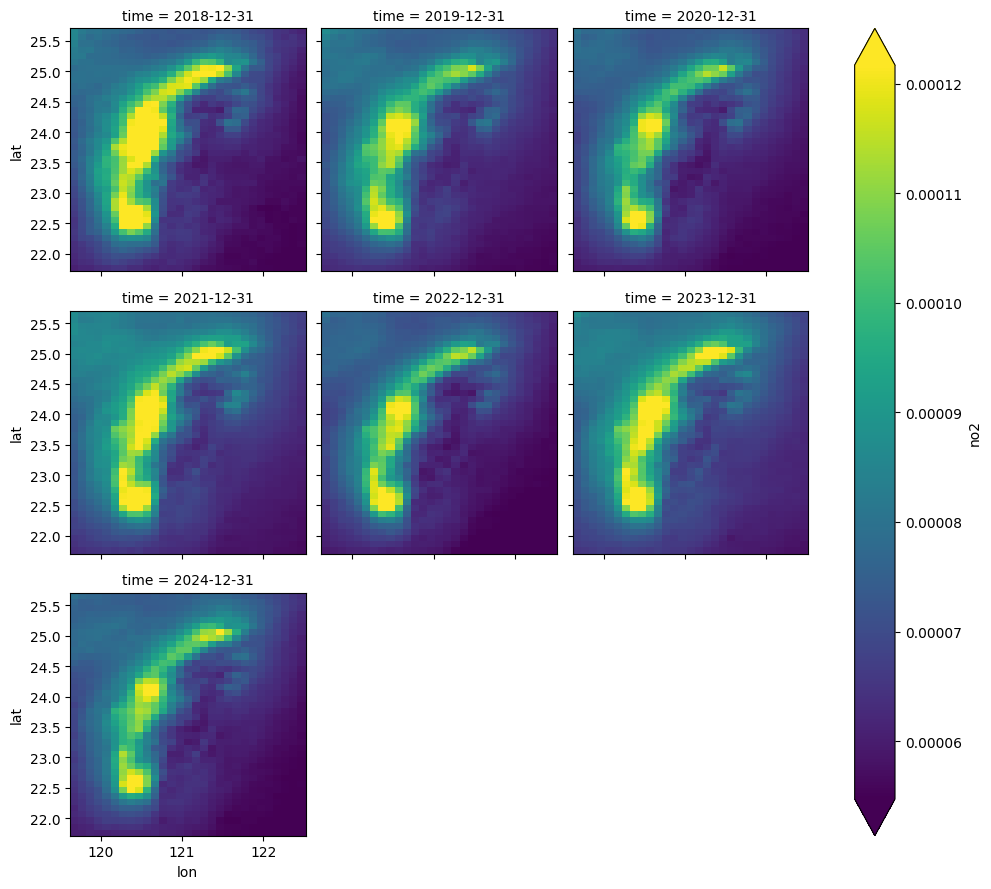

In [ ]:
annual.no2.plot(
    x = 'lon',
    y = 'lat',
    col='time',
    col_wrap=3,
    robust=True
    )

In [ ]:
annual_mean = annual.mean(dim = ['lon', 'lat'])
annual_mean

<xarray.Dataset> Size: 84B
Dimensions:  (time: 7)
Coordinates:
  * time     (time) datetime64[ns] 56B 2018-12-31 2019-12-31 ... 2024-12-31
Data variables:
    no2      (time) float32 28B 7.569e-05 7.448e-05 ... 7.867e-05 7.244e-05

<Axes: xlabel='time'>

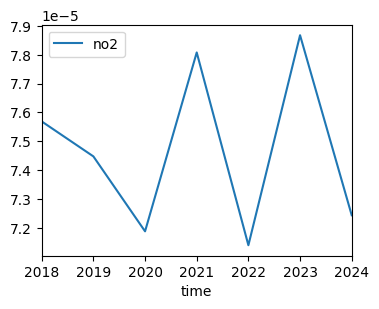

In [ ]:
annual_mean.to_dataframe().plot(figsize=(4, 3))

In [ ]:
annual_mean_df = annual_mean.to_dataframe()
annual_mean_df.reset_index(inplace=True)
annual_mean_df

,time,no2
0,2018-12-31,0.000076
1,2019-12-31,0.000074
2,2020-12-31,0.000072
3,2021-12-31,0.000078
4,2022-12-31,0.000071
5,2023-12-31,0.000079
6,2024-12-31,0.000072


In [ ]:
annual_mean_df['anomaly'] = annual_mean_df['no2'] - annual_mean_df['no2'].mean()
annual_mean_df

,no2,anomaly
time,,
2018-12-31,0.000076,1.025146e-06
2019-12-31,0.000074,-1.854496e-07
2020-12-31,0.000072,-2.780216e-06
2021-12-31,0.000078,3.414178e-06
2022-12-31,0.000071,-3.261317e-06
2023-12-31,0.000079,4.010893e-06
2024-12-31,0.000072,-2.223220e-06


In [ ]:
annual_mean_df = annual_mean_df.set_index("time")  # if there's a 'time' column


KeyError: "None of ['time'] are in the columns"

<Axes: xlabel='time'>

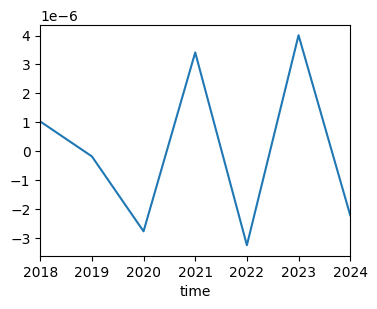

In [ ]:
annual_mean_df.anomaly.plot(figsize=(4, 3))

<Axes: ylabel='time'>

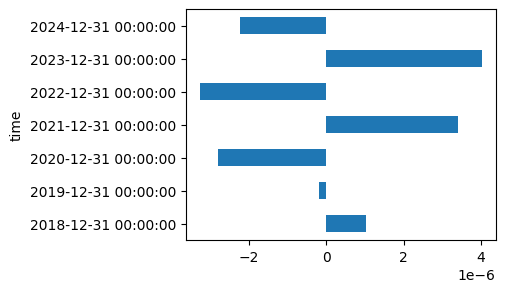

In [ ]:
annual_mean_df.anomaly.plot.barh(figsize=(4, 3))